In [1]:
import os
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import accuracy_score

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
# import tensorflow as tf
# print(tf.__version__)
# print(tf.config.list_physical_devices('GPU'))
# print(tf.test.is_built_with_cuda())

## Download dataset 
https://drive.google.com/drive/u/3/folders/1sHh6NvuKX6RB5OytLwf4kaqfQ9svJNDQ

## Load data

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
# It's a multi-class classification problem 
class_index = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
               'dog': 5, 'frog': 6,'horse': 7,'ship': 8, 'truck': 9}
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


![image](https://img-blog.csdnimg.cn/20190623084800880.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3lqcDE5ODcxMDEz,size_16,color_FFFFFF,t_70)

## Data preprocess

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to one-hot encoding (keras model requires one-hot label as inputs)
num_classes = 10
print(y_train[0])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

[9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Build model & training (Keras)

In [7]:
# # Build model (VGG16)
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(units=4096, activation='relu'))
# model.add(Dense(units=4096, activation='relu'))
# model.add(Dense(units=num_classes, activation='softmax'))

In [8]:
# Build model (modified from VGG16)
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(units=512))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule:
    Learning rate is scheduled to be reduced after specified epochs.
    Called automatically every epoch as part of callbacks during training.
    """
    lr = 0.01
    if epoch > 180:
        lr = 0.005
    elif epoch > 120:
        lr = 0.008
    elif epoch > 60:
        lr = 0.01
    elif epoch > 40:
        lr = 0.025
    elif epoch > 30:
        lr = 0.05
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [11]:
# initiate SGD optimizer
opt = keras.optimizers.SGD(lr=lr_schedule(0))

# Compile the model with loss function and optimizer, and evaluate with accuracy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Setup some hyperparameters
batch_size = 16
epochs = 250
data_augmentation = True


Learning rate:  0.01


In [12]:
# Model checkpoint: save best model
checkpoint = ModelCheckpoint(filepath='./best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [13]:
# Setup callbacks
callback_list = [PlotLossesKeras(), lr_scheduler, checkpoint]

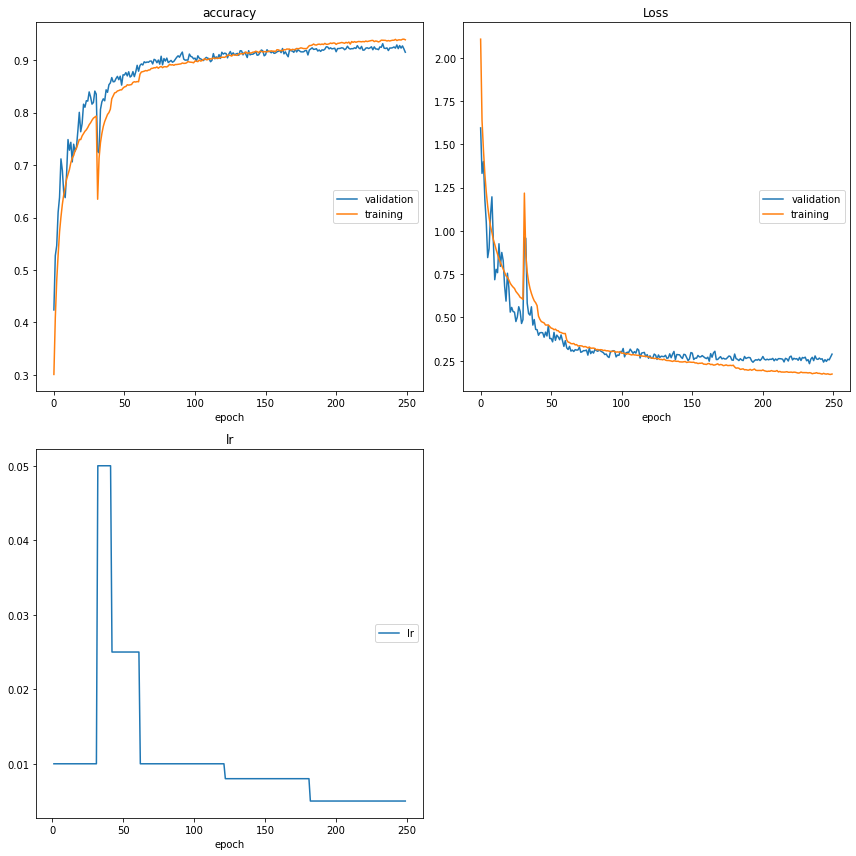

accuracy
	validation       	 (min:    0.424, max:    0.931, cur:    0.915)
	training         	 (min:    0.301, max:    0.940, cur:    0.939)
Loss
	validation       	 (min:    0.233, max:    1.595, cur:    0.288)
	training         	 (min:    0.171, max:    2.108, cur:    0.173)
lr
	lr               	 (min:    0.005, max:    0.050, cur:    0.005)

Epoch 00250: val_accuracy did not improve from 0.93120


In [14]:
if not data_augmentation:
    # Fit the data into model
    model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            shuffle=True,
            callbacks=callback_list)
else:
    print('Training with data augmentation...')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        rescale=0.9,
        rotation_range=2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4,
                        shuffle=True,
                        callbacks=callback_list)

In [15]:
y_pred = model.predict(x_test)
print(y_pred.shape) # 10000 samples, each sample with probaility of 10 classes

(10000, 10)


In [16]:
# y_pred[0] 

In [17]:
# np.argmax(y_pred[0]) # argmax to find the predict class with highest probability. 9=truck

In [18]:
# y_pred = np.argmax(y_pred, axis=1)

In [19]:
import h5py
filepath = 'last_model.h5'
model.save(filepath)

In [20]:
from keras.models import load_model
model = load_model('best_model.h5')

## DO NOT MODIFY CODE BELOW!
**Please screen shot your results and post it on your report**

In [21]:
# y_pred = your_model.predict(x_test)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [22]:
assert y_pred.shape == (10000,)

In [23]:
y_test = np.load("y_test.npy")
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))

Accuracy of my model on test set:  0.9312
